In [1]:
import csv
import numpy as np

from matplotlib import pyplot
%matplotlib inline

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
inputfile = './training.csv'
all = list(csv.reader(open(inputfile,"rb"), delimiter=','))
X = np.asarray([row[1:-2] for row in all[1:10000]]).astype(np.float)
y = np.asarray([row[-1] for row in all[1:10000]])
y[y=='s'] = 1.
y[y=='b'] = 0.
w = np.asarray([row[-2] for row in all[1:10000]]).astype(np.float)
X.shape

(9999, 30)

In [4]:
# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),
                         algorithm="SAMME.R",
                         n_estimators=200)
bdt.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=200, random_state=None)

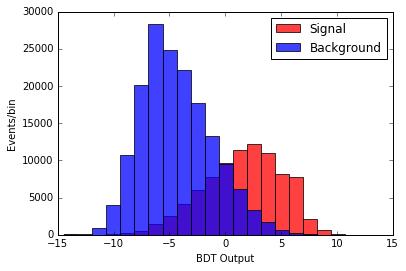

In [5]:
inputfile = './training.csv'
all = list(csv.reader(open(inputfile,"rb"), delimiter=','))
sX = np.asarray([row[1:-2] for row in all[1:] if row[-1]=='s']).astype(np.float)
bX = np.asarray([row[1:-2] for row in all[1:] if row[-1]=='b']).astype(np.float)
signal_output = bdt.decision_function(sX)
background_output = bdt.decision_function(bX)
plot_range = (min(signal_output.min(),background_output.min()), max(signal_output.max(),background_output.max()))
fig = pyplot.figure()
pyplot.hist(signal_output, bins=21, range=plot_range, alpha=0.75, facecolor = "r", label="Signal")
pyplot.hist(background_output, bins=21, range=plot_range, alpha=0.75, facecolor = "b", label="Background")
pyplot.legend(loc='upper right')
pyplot.ylabel('Events/bin')
pyplot.xlabel('BDT Output')
pyplot.show()

In [106]:
data_train = np.loadtxt( 'training.csv', delimiter=',', skiprows=1, converters={32: lambda x:int(x=='s'.encode('utf-8')) } )
data_test = np.loadtxt( 'test.csv', delimiter=',', skiprows=1 )
Y_train = data_train[:,32]
X_train = data_train[:,1:31]
W_train = data_train[:,31]
X_test = data_test[:,1:31]

mjj = data_train[:,6]
deta= data_train[:,5][mjj>200]

X_train = X_train[deta>2]
Y_train = Y_train[deta>2]
W_train = W_train[deta>2]

/cvmfs/sft.cern.ch/lcg/views/LCG_87/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 250000 but corresponding boolean dimension is 39573
/cvmfs/sft.cern.ch/lcg/views/LCG_87/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 250000 but corresponding boolean dimension is 39573
/cvmfs/sft.cern.ch/lcg/views/LCG_87/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 250000 but corresponding boolean dimension is 39573


In [137]:
prob_predict_train = bdt.predict_proba(X_train)[:,1]
pcut = np.percentile(prob_predict_train,80)

In [152]:
Classifier_training_S = (bdt.predict_proba(X_train[Y_train>0.5])[:,1].ravel(),W_train[Y_train>0.5][:].ravel())
Classifier_training_B = (bdt.predict_proba(X_train[Y_train<0.5])[:,1].ravel(),W_train[Y_train<0.5][:].ravel())
Classifier_testing_A = bdt.predict_proba(X_test)[:,1].ravel()

In [153]:
c_max = max([Classifier_training_S[0].max(),Classifier_training_B[0].max(),Classifier_testing_A.max()])
c_min = min([Classifier_training_S[0].min(),Classifier_training_B[0].min(),Classifier_testing_A.min()])
Histo_training_S = np.histogram(Classifier_training_S[0],bins=25,range=(c_min,c_max),weights=10*Classifier_training_S[1])
Histo_training_B = np.histogram(Classifier_training_B[0],bins=25,range=(c_min,c_max),weights=Classifier_training_B[1])
Histo_testing_A = np.histogram(Classifier_testing_A,bins=25,range=(c_min,c_max))

AllHistos= [Histo_training_S,Histo_training_B]
h_max = max([histo[0].max() for histo in AllHistos])*1.2
h_min = min([histo[0].min() for histo in AllHistos])

bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])

# To make error bar plots for the data, take the Poisson uncertainty sqrt(N)
ErrorBar_testing_A = np.sqrt(Histo_testing_A[0])

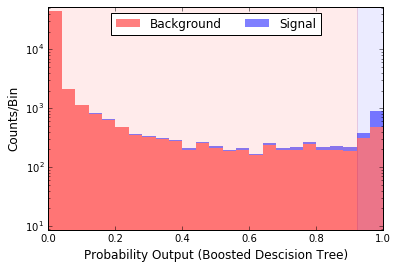

In [154]:
ax1 = pyplot.subplot(111)
# Draw solid histograms for the training data
ax1.bar(bin_centers-bin_widths/2.,Histo_training_B[0],facecolor='red',linewidth=0,width=bin_widths,label='Background',alpha=0.5,log=True)
ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],bottom=Histo_training_B[0],facecolor='blue',linewidth=0,width=bin_widths,label='Signal',alpha=0.5,log=True)
 
ff = (1.0*sum(W_train))/(1.0*len(X_test))
 
# # Draw error-bar histograms for the testing data
#ax1.errorbar(bin_centers, ff*Histo_testing_A[0], yerr=ff*ErrorBar_testing_A, xerr=None, ecolor='black',c='black',fmt='.',label='Test (reweighted)')
# ax1.errorbar(bin_centers, Histo_testing_B[0], yerr=ErrorBar_testing_B, xerr=None, ecolor='red',c='red',fmt='o',label='B (Test)')
cutbin = pcut-(pcut%bin_widths[0])
# Make a colorful backdrop to show the clasification regions in red and blue
ax1.axvspan(cutbin, c_max, color='blue',alpha=0.08)
ax1.axvspan(c_min, cutbin, color='red',alpha=0.08)
  
# Adjust the axis boundaries (just cosmetic)
ax1.axis([c_min, c_max, h_min, h_max])
# Make labels and title
#pyplot.title("Kaggle Higgs Machine Learning Challenge Signal-Background Separation")
pyplot.xlabel("Probability Output (Boosted Descision Tree)",fontsize='large')
pyplot.ylabel("Counts/Bin",fontsize='large')
 
# Make legend with smalll font
legend = ax1.legend(loc='upper center',ncol=2)
for alabel in legend.get_texts():
            alabel.set_fontsize('large')
  
# Save the result to png
pyplot.savefig("VBF_bdt.pdf")

In [148]:
SR_s = ([event[0] for event in zip(Classifier_training_S[0],Classifier_training_S[1]) if event[0]>pcut],
        [event[1]*10 for event in zip(Classifier_training_S[0],Classifier_training_S[1]) if event[0]>pcut])
SR_b = ([event[0] for event in zip(Classifier_training_B[0],Classifier_training_B[1]) if event[0]>pcut],
        [event[1] for event in zip(Classifier_training_B[0],Classifier_training_B[1]) if event[0]>pcut])

In [149]:
c_min=pcut
c_max=1.

Histo_SR_S = np.histogram(SR_s[0],bins=5,range=(c_min,c_max),weights=SR_s[1])
Histo_SR_B = np.histogram(SR_b[0],bins=5,range=(c_min,c_max),weights=SR_b[1])
AllHistos= [Histo_SR_S,Histo_SR_B]
h_max = max([histo[0].max() for histo in AllHistos])*1.2
h_min = min([histo[0].min() for histo in AllHistos])

bin_edges = Histo_SR_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])

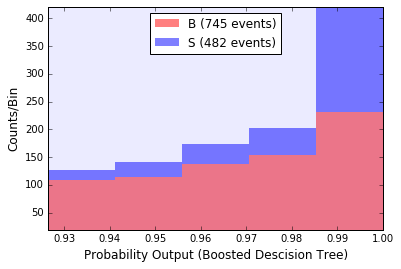

In [151]:
ax1 = pyplot.subplot(111)
N_background = sum(SR_b[1])
N_signal = sum(SR_s[1])
# Draw solid histograms for the training data
ax1.bar(bin_centers-bin_widths/2.,Histo_SR_B[0],facecolor='red',linewidth=0,width=bin_widths,label='B ({0:.0f} events)'.format(N_background),alpha=0.5)
ax1.bar(bin_centers-bin_widths/2.,Histo_SR_S[0],bottom=Histo_SR_B[0],facecolor='blue',linewidth=0,width=bin_widths,label='S ({0:.0f} events)'.format(N_signal),alpha=0.5)
 
ax1.axvspan(pcut, c_max, color='blue',alpha=0.08)
#ax1.axvspan(c_min,pcut, color='red',alpha=0.08)

# Adjust the axis boundaries (just cosmetic)
ax1.axis([c_min, c_max, h_min, h_max])
# Make labels and title
#pyplot.title("Kaggle Higgs Machine Learning Challenge Signal-Background Separation")
pyplot.xlabel("Probability Output (Boosted Descision Tree)",fontsize='large')
pyplot.ylabel("Counts/Bin",fontsize='large')
 
# Make legend with smalll font
legend = ax1.legend(loc='upper center',ncol=1)
for alabel in legend.get_texts():
            alabel.set_fontsize('large')
  
# Save the result to png
pyplot.savefig("SR_bdt.pdf")